# Pairs Trading Dogecoin and Shiba Inu with Alpaca’s Crypto API

## What is Pairs Trading?

**The Basics**

Pairs Trading is a strategy that attempts to exploit the difference in returns of two highly correlated assets. From time to time, one of the two assets that are nearly identical in price action will start outperforming the other. Pairs trading would short the outperforming asset, and go long the underperforming asset hoping that the returns will revert back to the mean.

**The Benefits of Pairs Trading**

Pairs trading is a market-neutral strategy, meaning that the overall trend of the market does not have an outsized influence on potential returns. Since there is always 1:1 long and short exposure on two highly correlated assets, the benefits are that the downside should theoretically be capped.

**The Setbacks of Pairs Trading**

Correlated assets can become uncorrelated at any moment and what has worked in the past is never guaranteed to work in the future.

## Pairs Trading Dogecoin and Shiba Inu with Historical Data

**Download Dependencies**

First, we must pip install (download) all the required dependencies for the program. These dependencies are what make it possible to collect and calculate the data we need to build the trading bot.

In [ ]:
%%capture
!pip install alpaca_trade_api
!pip install plotly
!pip install pyyaml==5.4.1
!pip install nest-asyncio

**Import Modules**

Once we have downloaded the dependencies, we have to import them in order to use them in the program.

In [ ]:
# Import dependencies
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
from alpaca_trade_api.rest import REST, TimeFrame
import plotly.graph_objects as go
import plotly.express as px
import nest_asyncio
nest_asyncio.apply()

**Setup**

Here, we have to define some of the variables we will be using later on such as the stock ticker, start date, and end date. In order to access the historical stock price data from the Alpaca API, you must create an account and collect your API/secret keys. Don't worry, it's completely free and you can just sign up for a paper trading account!

In [ ]:
# API keys for Alpaca
API_KEY = 'APCA-API-KEY-ID'
SECRET_KEY = 'APCA-API-SECRET-KEY'

# Setup instance of Alpaca API
rest_api = tradeapi.REST(API_KEY, SECRET_KEY,'https://paper-api.alpaca.markets')

# Start and end dates for historical data
start_date = datetime.date.today() - datetime.timedelta(days=int(160))
end_date = datetime.date.today()

**Retrieve and Calculate Data**

Using the Alpaca REST API, we can retrieve the historical crypto price data into a Pandas DataFrame. Then, we can create extra columns with the data we need to calculate for our pairs trading strategy.

In this case, we require two columns for each cryptocurrency. One for the daily price returns and the other column for cumulative returns.

In [ ]:
# Retrieve daily price data for Dogecoin and Shiba Inu cryptocurrencies for last 160 days
doge = rest_api.get_crypto_bars("DOGEUSD", TimeFrame.Day, start_date, end_date).df
shib = rest_api.get_crypto_bars("SHIBUSD", TimeFrame.Day, start_date, end_date).df

# Create column of daily return percentages
doge["DOGE_daily_return"] = doge["close"].pct_change()
shib["SHIB_daily_return"] = shib["close"].pct_change()

# Create column of cumulative return percentages
doge["DOGE_return"] = doge["DOGE_daily_return"].add(1).cumprod().sub(1)
shib["SHIB_return"] = shib["SHIB_daily_return"].add(1).cumprod().sub(1)

**Visualizing Dogecoin and Shiba Inu Historical Returns**

Here, we can plot the cumulative returns for Dogecoin and Shiba Inu for the past 160 days to visualize if there is any correlation. In this particular situation, we can see there seems to be a strong correlation between the two cryptos. That's perfect for pairs trading!

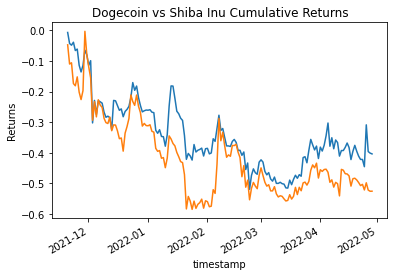

In [ ]:
# Visualize Correlation Between Dogecoin and Shiba Inu Historical Returns
ax = doge["DOGE_return"].plot(title="Dogecoin vs Shiba Inu Cumulative Returns")
shib["SHIB_return"].plot(ax=ax)
ax.set_ylabel("Returns")
plt.show()

**Calculate and Visualize Historical Spread**

Next, we can calculate the spread (difference) in the cumulative returns by subtracting Shiba Inu's cumulative return from Dogecoin's. We can plot the difference in returns as a line chart and view the pattern to see if the spread tends to mean revert back to 0.

We can also create a histogram of the spread to see if it resembles a normal distribution with a mean of 0. Adding the upper and lower standard deviations can give a better sense of what each data point represents in context of the whole!

In Dogecoin and Shiba Inu's case, it seems that Dogecoin tends to outperform more than Shiba Inu does on average. It’s important to test out hypotheses (Dogecoin and Shiba Inu are correlated) historically before implementing them live in order to assess whether they are in fact true and to note tendencies like how Dogecoin tends to outperform Shiba Inu or after what standard deviation, do returns tend to converge.

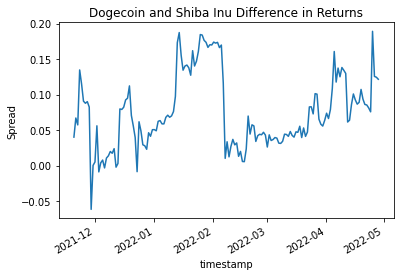

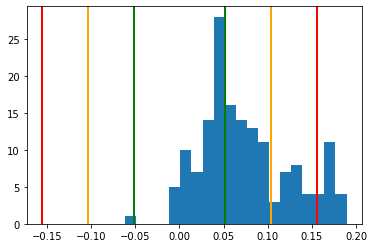

In [ ]:
# Calculate the spread (difference) in cumulative returns
data = pd.DataFrame()
data["DOGE_return"] = doge["DOGE_return"]
data["SHIB_return"] = shib["SHIB_return"]
data["spread"] = data["DOGE_return"] - data["SHIB_return"]

# Visualize the spread (difference) in cumulative returns 
ax = data["spread"].plot(title="Dogecoin and Shiba Inu Difference in Returns")
ax.set_ylabel("Spread")
plt.show()

# Create column for the standard deviation of spread values
data["spread_std"] = data["spread"].std()

# Create new columns for positive and negative multiples of the standard deviation
data["spread_upper_std"] = 1 * data["spread_std"]
data["spread_lower_std"] = -1 * data["spread_std"]

# Plotting standard deviations on spread histogram
plt.hist(data["spread"], bins=20)
plt.axvline(data["spread_upper_std"].mean() * 1, color='g', linestyle='-', lw=2, label="1 stdev")
plt.axvline(data["spread_upper_std"].mean() * 2, color='orange', linestyle='-', lw=2, label="2 stdev")
plt.axvline(data["spread_upper_std"].mean() * 3, color='r', linestyle='-', lw=2, label="3 stdev")
plt.axvline(data["spread_lower_std"].mean() * 1, color='g', linestyle='-', lw=2)
plt.axvline(data["spread_lower_std"].mean() * 2, color='orange', linestyle='-', lw=2)
plt.axvline(data["spread_lower_std"].mean() * 3, color='r', linestyle='-', lw=2)
plt.show()

## Pairs Trading Dogecoin and Shiba Inu with Live Market Data

Now that we’ve viewed the historical representation of Dogecoin and Shiba Inu’s correlation and spread, we can go ahead and start implementing a live strategy!

**Alpaca Does Not Support Shorting Cryptocurrency**

Alpaca does not support shorting cryptocurrency so to simulate the shorting side of pairs trading, we can hold 50% of our portfolio each in Dogecoin and Shiba Inu. Then, when going long on Dogecoin, for example, we can sell our long Shiba Inu position and buy the same notional amount of Dogecoin. 


In [ ]:
# retrieve cash from account details
cash = float(rest_api.get_account().cash)
shib_notional_size = cash / 2
doge_notional_size = cash / 2

# Place half portolfio cash buy order for SHIB
rest_api.submit_order(symbol="SHIBUSD", notional=shib_notional_size, type="market", side="buy", time_in_force="day")

# Place half portfolio cash buy order for DOGE
rest_api.submit_order(symbol="DOGEUSD",notional=doge_notional_size, type="market", side="buy", time_in_force="day")

**Calculating Real-Time Spread**

Using the input of a live data stream of prices for Dogecoin and Shiba Inu, we can start calculating the values we need to create our buy and sell signals. First, we need to make sure the data is matched up for both cryptos, and then we can store the current spread. 

**Creating Entry/Exit Signals**

Using the historical standard deviation spread of Dogecoin vs. Shiba Inu, we can create an entry-level for Dogecoin when the current spread is below the negative historical standard deviation of the spread. Then, we can create a stop loss level at -3 times the historical standard deviation of the spread. We can create the same types of entry/exit signals except on the positive side of the historical standard deviation of the spread, for long Shiba Inu.

**Simulating Pairs Trading Orders with Python**

Lastly, given that there are currently both Dogecoin and Shiba Inu in the portfolio, we can continue to monitor the current spread values to the entry signals to see if they trigger.

If there is currently one long position in the portfolio, that means we can instead look for exit signals which are either the stop loss previously defined or a take-profit when the current spread converges back to 0.

We can submit orders through the rest API by simply passing in the symbol, notional (dollar amount to buy), type of order (market or limit), side (buy or sell), and time_in_force or how long the order will last if not filled immediately.

**Streaming Market Data from Alpaca**

After setting up the data and order functions, we can start streaming live market data from Alpaca. We can use Alpaca’s Stream method to subscribe to continuous data for DOGEUSD and SHIBUSD.

In [ ]:
def calculate_live_spread(bar):
    # Define dictionary to organize our data
    data = {}

    # Convert bar timestamp to human readable form
    time = datetime.datetime.fromtimestamp(bar.timestamp / 1000000000)
    symbol = bar.symbol

    # If we’ve reached this point, then we have data for both symbols for the current timestamp
    data[time][symbol] = bar

    # retrieve dictionary containing bar data from a single timestamp
    timeslice = data[time]

    # access bar data
    doge_data = timeslice["DOGEUSD"]
    shib_data = timeslice["SHIBUSD"]

    # save reference of close data for each bar
    doge_close = doge_data.close
    shib_close = shib_data.close

    # calculate spread
    spread = doge_close - shib_close

    # we will use the historical STD
    spread_std = timeslice["spread_std"]
    
    # calculate entry and exit levels for standard deviation (dogecoin long, shiba inu short)
    doge_entry_level = -1 * spread_std
    doge_loss_exit_level = -3 * spread_std

    # calculate entry and exit levels for standard deviation (shiba inu long, dogecoin short)
    shib_entry_level = 1 * spread_std
    shib_loss_exit_level = 3 * spread_std

    # pass spread and level data to next part for placing trades
    place_trades(spread, doge_entry_level, doge_loss_exit_level, shib_entry_level, shib_loss_exit_level)

def place_trades(spread, doge_entry_level, doge_loss_exit_level, shib_entry_level, shib_loss_exit_level):
    # there is an active position if there is 1 position
    active_position = len(rest_api.list_positions()) == 1
    
    if spread < doge_entry_level and not active_position:
        if rest_api.list_positions()[0].symbol == "SHIBUSD":
            shib_qty = rest_api.list_positions()[0].qty
        else:
            shib_qty = rest_api.list_positions()[1].qty

        # Place sell order for SHIB
        rest_api.submit_order(symbol="SHIBUSD", type="market", qty=shib_qty/2, side="sell", time_in_force="day")

        # place long order on DOGEUSD
        doge_notional_size = float(rest_api.get_account().cash)
        rest_api.submit_order(symbol="DOGEUSD", notional=doge_notional_size, type="market", side="buy", time_in_force="day")

    if spread > shib_entry_level and not active_position:
        if rest_api.list_positions()[0].symbol == "DOGEUSD":
            doge_qty = rest_api.list_positions()[0].qty
        else:
            doge_qty = rest_api.list_positions()[1].qty

        # Place sell order for DOGE
        rest_api.submit_order(symbol="DOGEUSD", type="market", qty=doge_qty/2, side="sell", time_in_force="day")

        # place long order on SHIBUSD
        shib_notional_size = float(rest_api.get_account().cash)
        rest_api.submit_order(symbol="SHIBUSD", notional=shib_notional_size, type="market", side="buy", time_in_force="day")

    elif spread < doge_loss_exit_level and active_position and (rest_api.list_positions()[0].symbol == "DOGEUSD"):
        # liquidate if loss exit level is breached
        if rest_api.list_positions()[0].symbol == "DOGEUSD":
            doge_qty = rest_api.list_positions()[0].qty
        else:
            doge_qty = rest_api.list_positions()[1].qty

        # Place sell order for DOGE
        rest_api.submit_order(symbol="DOGEUSD", type="market", qty=doge_qty/2, side="sell", time_in_force="day")

        # place long order on SHIBUSD
        shib_notional_size = float(rest_api.get_account().cash)
        rest_api.submit_order(symbol="SHIBUSD", notional=shib_notional_size, type="market", side="buy", time_in_force="day")

    elif spread > 0 and active_position and (rest_api.list_positions()[0].symbol == "DOGEUSD"):
        if rest_api.list_positions()[0].symbol == "DOGEUSD":
            doge_qty = rest_api.list_positions()[0].qty
        else:
            doge_qty = rest_api.list_positions()[1].qty

        # Place sell order for DOGE
        rest_api.submit_order(symbol="DOGEUSD", type="market", qty=doge_qty/2, side="sell", time_in_force="day")

        # place long order on SHIBUSD
        shib_notional_size = float(rest_api.get_account().cash)
        rest_api.submit_order(symbol="SHIBUSD", notional=shib_notional_size, type="market", side="buy", time_in_force="day")

    elif spread > shib_loss_exit_level and active_position and (rest_api.list_positions()[0].symbol == "SHIBUSD"):
        # liquidate if loss exit level is breached

        if rest_api.list_positions()[0].symbol == "SHIBUSD":
            shib_qty = rest_api.list_positions()[0].qty
        else:
            shib_qty = rest_api.list_positions()[1].qty

        # Place sell order for SHIBUSD
        rest_api.submit_order(symbol="SHIBUSD", type="market", qty=shib_qty/2, side="sell", time_in_force="day")

        # place long order on DOGEUSD
        doge_notional_size = float(rest_api.get_account().cash)
        rest_api.submit_order(symbol="DOGEUSD", notional=doge_notional_size, type="market", side="buy", time_in_force="day")

    elif spread < 0 and active_position and (rest_api.list_positions()[0].symbol == "SHIBUSD"):
        # liquidate if 0 spread is crossed with an active position

        if rest_api.list_positions()[0].symbol == "SHIBUSD":
            shib_qty = rest_api.list_positions()[0].qty
        else:
            shib_qty = rest_api.list_positions()[1].qty

        # Place sell order for SHIB
        rest_api.submit_order(symbol="SHIBUSD", type="market", qty=shib_qty/2, side="sell", time_in_force="day")

        # place long order on DOGEUSD
        doge_notional_size = float(rest_api.get_account().cash)
        rest_api.submit_order(symbol="DOGEUSD", notional=doge_notional_size, type="market", side="buy", time_in_force="day")

# Create instance of Alpaca data streaming API
alpaca_stream = tradeapi.Stream(API_KEY, SECRET_KEY)

# Create handler for receiving live bar data for Dogecoin and Shiba Inu
async def on_crypto_bar(bar):
    print(bar)
    calculate_live_spread(bar)

# Subscribe to Shiba Inu token data and assign handler
alpaca_stream.subscribe_crypto_bars(on_crypto_bar, "DOGEUSD", "SHIBUSD")

# Start streaming of data
alpaca_stream.run()

## Conclusion

Using the Alpaca API, we visualized the pairs trading strategy in action both historically and in live market conditions. Since cryptocurrency cannot be shorted on Alpaca, we had to simulate a workaround by holding standard 50% weights of both the cryptos in the portfolio. However, the same pairs trading strategy can be applied in live market conditions to stocks where shorting is available.

Thanks for reading, and I hope you learned something about Pairs Trading with the Alpaca Crypto API!